# k-Greedy

## 1. Setup

In [314]:
import copy
from typing import Optional, List


import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoModel

## 2. Select k

In [292]:
def cosine_similarity(x1: torch.Tensor, x2: torch.Tensor, eps: float = 1e-8):
    x1_norm = x1.norm(dim=1).unsqueeze(1)
    x2_norm = x2.norm(dim=1).unsqueeze(1)

    x1_norm = torch.max(x1_norm, eps * torch.ones_like(x1_norm))
    x2_norm = torch.max(x2_norm, eps * torch.ones_like(x2_norm))

    x1 = x1 / x1_norm
    x2 = x2 / x2_norm

    sim = torch.mm(x1, x2.transpose(-1, -2))
    return sim

def k_center_greedy(k: int, dist: torch.Tensor):
    clusters = [0]
    for i in range(k - 1):
        c_dist, _ = dist[clusters].min(dim=0) # 가장 가까운 cluster와의 거리
        cands = (-c_dist).argsort() # 가장 가까운 cluster와의 거리가 가장 먼 point
        for c in cands:
            if c not in clusters:
                clusters.append(int(c))
                break
    return clusters

In [295]:
model = AutoModel.from_pretrained('klue/bert-base')

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [296]:
embedding = model.base_model.embeddings.word_embeddings.weight.data.transpose(-1, -2)

In [297]:
sim = cosine_similarity(embedding, embedding)
sim = sim.abs()
dist = -sim

In [308]:
indices = k_center_greedy(384, dist)
indices = sorted(indices)

In [309]:
new_embedding = embedding[indices]
new_sim = cosine_similarity(new_embedding, new_embedding)
new_sim = new_sim.abs()

In [463]:
help(model.save_pretrained)

Help on method save_pretrained in module transformers.modeling_utils:

save_pretrained(save_directory: Union[str, os.PathLike], save_config: bool = True, state_dict: Union[dict, NoneType] = None, save_function: Callable = <function save at 0x7f6c6664a9d0>, push_to_hub: bool = False, **kwargs) method of transformers.models.bert.modeling_bert.BertModel instance
    Save a model and its configuration file to a directory, so that it can be re-loaded using the
    `:func:`~transformers.PreTrainedModel.from_pretrained`` class method.
    
    Arguments:
        save_directory (:obj:`str` or :obj:`os.PathLike`):
            Directory to which to save. Will be created if it doesn't exist.
        save_config (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether or not to save the config of the model. Useful when in distributed training like TPUs and need
            to call this function on all processes. In this case, set :obj:`save_config=True` only on the main
            

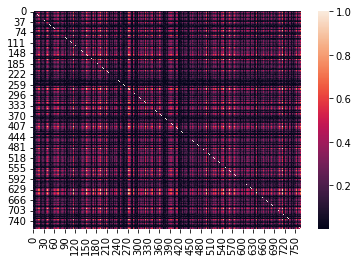

In [310]:
sns.heatmap(sim)
plt.show()

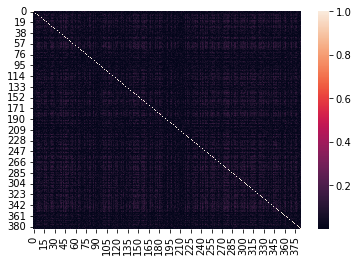

In [311]:
sns.heatmap(new_sim)
plt.show()

## 3. Select weight

In [432]:
def select_embedding(embedding: nn.Embedding, indices: List[int]):
    new_embedding = nn.Embedding(embedding.num_embeddings, len(indices))
    new_embedding.weight.data = embedding.weight.data[:, indices]
    return new_embedding

def select_layernorm(layernorm: nn.LayerNorm, indices: List[int]):
    new_layernorm = nn.LayerNorm(len(indices), eps=layernorm.eps, elementwise_affine=layernorm.elementwise_affine)
    new_layernorm.weight.data = layernorm.weight.data[indices]
    new_layernorm.bias.data = layernorm.bias.data[indices]
    return new_layernorm

def select_linear(linear: nn.Linear, indices: List[int], select_in_features: bool, select_out_features: bool):
    if select_in_features:
        in_features = len(indices)
        in_features_indices = indices    
    else:
        in_features = linear.in_features
        in_features_indices = list(range(in_features))
        
    if select_out_features:
        out_features = len(indices)
        out_features_indices = indices
    else:
        out_features = linear.out_features
        out_features_indices = list(range(out_features))

    bias = linear.bias is not None    
    new_linear = nn.Linear(in_features, out_features, bias=bias)
    
    new_linear.weight.data = linear.weight.data[out_features_indices][:,in_features_indices]
    if bias:
        new_linear.bias.data = linear.bias.data[out_features_indices]
    
    return new_linear

In [444]:
def select_layers(model: torch.nn.Module, indices: List[int]):
    model.encoder.layer = nn.ModuleList([l for i, l in enumerate(model.encoder.layer) if i in indices])

def select_bert_embeddings(bert_embeddings: nn.Module, indices: List[int]):
    bert_embeddings.word_embeddings = select_embedding(bert_embeddings.word_embeddings, indices)
    bert_embeddings.position_embeddings = select_embedding(bert_embeddings.position_embeddings, indices)
    bert_embeddings.token_type_embeddings = select_embedding(bert_embeddings.token_type_embeddings, indices)
    bert_embeddings.LayerNorm = select_layernorm(bert_embeddings.LayerNorm, indices)
    
    
def select_bert_layer(bert_layer: nn.Module, indices: List[int]):
    bert_layer.attention.self.all_head_size = len(indices)
    bert_layer.attention.self.attention_head_size = len(indices) // bert_layer.attention.self.num_attention_heads
    
    bert_layer.attention.self.query = select_linear(bert_layer.attention.self.query, indices, select_in_features=True, select_out_features=True)
    bert_layer.attention.self.key = select_linear(bert_layer.attention.self.key, indices, select_in_features=True, select_out_features=True)
    bert_layer.attention.self.value = select_linear(bert_layer.attention.self.value, indices, select_in_features=True, select_out_features=True)

    bert_layer.attention.output.dense = select_linear(bert_layer.attention.output.dense, indices, select_in_features=True, select_out_features=True)
    bert_layer.attention.output.LayerNorm = select_layernorm(bert_layer.attention.output.LayerNorm, indices)

    bert_layer.intermediate.dense = select_linear(bert_layer.intermediate.dense, indices, select_in_features=True, select_out_features=False)

    bert_layer.output.dense = select_linear(bert_layer.output.dense, indices, select_in_features=False, select_out_features=True)
    bert_layer.output.LayerNorm = select_layernorm(bert_layer.output.LayerNorm, indices)
    
def select_bert_pooler(bert_pooler: nn.Module, indices: List[int]):
    bert_pooler.dense = select_linear(bert_pooler.dense, indices, select_in_features=True, select_out_features=True)

In [450]:
def select_bert_model(bert_model:nn.Module, layer_indices: List[int], weight_indices: List[int]):
    select_layers(bert_model, layer_indices)
    select_bert_embeddings(bert_model.embeddings, weight_indices)
    for bert_layer in bert_model.encoder.layer:
        select_bert_layer(bert_layer, weight_indices)
    select_bert_pooler(model.pooler, weight_indices)

In [445]:
model = AutoModel.from_pretrained('klue/bert-base')

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [460]:
model.config

BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

In [451]:
layer_indices = [i for i in range(12) if i % 2 != 0]
weight_indices = indices
select_bert_model(model, layer_indices, weight_indices)

In [452]:
inputs = torch.randint(low=0, high=1000, size=(1, 32))

In [455]:
out = model(inputs, output_hidden_states=True, output_attentions=True)

In [459]:
out.hidden_states[0].size()

torch.Size([1, 32, 384])

In [430]:
bert_layer = model.encoder.layer[0]
bert_layer

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=384, out_features=384, bias=True)
      (key): Linear(in_features=384, out_features=384, bias=True)
      (value): Linear(in_features=384, out_features=384, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=384, out_features=384, bias=True)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=384, out_features=3072, bias=True)
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=384, bias=True)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [461]:
model.config

BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}